In [ ]:

import os, shutil, random, pandas as pd, numpy as np, datetime
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19, ResNet50
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# AdamW import (supports TF 2.11+); fallback to experimental
try:
    from tensorflow.keras.optimizers import AdamW, SGD
except Exception:
    from tensorflow.keras.optimizers.experimental import AdamW
    from tensorflow.keras.optimizers import SGD

print(tf.__version__)


2.19.0


### Create Train/Validation/Test Split from a single `dataset/original/`

In [ ]:
def split_data(source_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1.0"
    for cls in os.listdir(source_dir):
        src = os.path.join(source_dir, cls)
        if not os.path.isdir(src):
            continue
        imgs = [os.path.join(src, f) for f in os.listdir(src) if not f.startswith('.')]
        random.shuffle(imgs)
        n = len(imgs)
        n_tr = int(train_ratio * n)
        n_val = int(val_ratio * n)
        splits = {
            'train': imgs[:n_tr],
            'val':   imgs[n_tr:n_tr+n_val],
            'test':  imgs[n_tr+n_val:]
        }
        for split, paths in splits.items():
            dst = os.path.join('/content/drive/MyDrive/dataset', split, cls)
            os.makedirs(dst, exist_ok=True)
            for p in paths:
                shutil.copy(p, dst)

# Run once if you start from dataset/original
split_data('dataset/original')


###  2) Data Preprocessing & Augmentation (ImageNet normalization, 224×224)

In [ ]:
# Clean stray .ipynb_checkpoints
for p in [
    'dataset/train/.ipynb_checkpoints',
    'dataset/val/.ipynb_checkpoints',
    'dataset/test/.ipynb_checkpoints'
]:
    if os.path.exists(p):
        shutil.rmtree(p)

# Augmentation for training; val/test only normalization
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest'
)
val_datagen  = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

def make_gens(batch_size=16):
    train_gen = train_datagen.flow_from_directory(
        'dataset/train', target_size=(224,224), class_mode='binary', batch_size=batch_size
    )
    val_gen = val_datagen.flow_from_directory(
        'dataset/val', target_size=(224,224), class_mode='binary', batch_size=batch_size
    )
    test_gen = test_datagen.flow_from_directory(
        'dataset/test', target_size=(224,224), class_mode='binary', batch_size=batch_size, shuffle=False
    )
    return train_gen, val_gen, test_gen

# Default generators (can be recreated per run with different batch sizes)
train_gen, val_gen, test_gen = make_gens(batch_size=16)


Found 51 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 13 images belonging to 2 classes.


### 3) Model Factory (VGG19 / ResNet50) + Top Classifier

In [5]:
def build_base(model_name):
    Base = VGG19 if model_name == 'VGG19' else ResNet50
    return Base(weights='imagenet', include_top=False, input_shape=(224,224,3))

def build_model(base_model, dropout):
    base_model.trainable = False  # fine-tuning only later
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout)(x)
    out = Dense(1, activation='sigmoid')(x)
    return Model(inputs=base_model.input, outputs=out)


### 4) Training Helper (scheduler + early stopping + validation metrics)

In [6]:
def cosine_lr_schedule(epoch, lr_max, T=30):
    # Cosine over epochs
    return float(lr_max * (1 + np.cos(np.pi * epoch / T)) / 2)

def compile_with_optimizer(model, optimizer_name, lr, weight_decay):
    if optimizer_name == 'AdamW':
        opt = AdamW(learning_rate=lr, weight_decay=weight_decay)
    else:  # SGD
        opt = SGD(learning_rate=lr, momentum=0.9, decay=weight_decay)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_and_validate(model_name, params, train_gen, val_gen):
    base = build_base(model_name)
    model = build_model(base, params['dropout'])
    model = compile_with_optimizer(model, params['optimizer'], params['lr'], params['weight_decay'])

    callbacks = [EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)]
    if params['scheduler'] == 'Cosine':
        callbacks.append(LearningRateScheduler(lambda e: cosine_lr_schedule(e, params['lr'], T=max(params['epochs'], 1))))

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=params['epochs'],
        callbacks=callbacks,
        verbose=1
    )

    # Validation metrics
    y_true = val_gen.classes
    y_pred = (model.predict(val_gen) > 0.5).astype('int32')
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return model, (acc, prec, rec, f1), history


### 5) Hyperparameter Search Space (as per instructions)

In [7]:
search_grid = [
    {'lr': lr, 'optimizer': opt, 'weight_decay': wd, 'dropout': dp, 'batch': bs, 'scheduler': sch, 'epochs': ep}
    for lr in [1e-5, 3e-5, 1e-4, 3e-4]
    for opt in ['AdamW', 'SGD']
    for wd in [0, 1e-5, 1e-4, 1e-3]
    for dp in [0.0, 0.3, 0.5]
    for bs in [8, 16, 32]
    for sch in ['None', 'Cosine']
    for ep in [10, 20, 30]
]

# To limit runtime in class/Colab, cap number of runs
MAX_RUNS = 4  # increase if you have more time/GPU
len(search_grid)


1728

### 6) Experiment Loop + CSV Logging

In [ ]:
LOG_FILE = 'experiment_log.csv'
if not os.path.exists(LOG_FILE):
    pd.DataFrame(columns=[
        'Time','Model','LR','Optimizer','WeightDecay','Dropout','Batch','Scheduler','Epochs',
        'ValAcc','ValPrecision','ValRecall','ValF1'
    ]).to_csv(LOG_FILE, index=False)

all_results = []

models_to_try = ['VGG19', 'ResNet50']
run_idx = 0
for model_name in models_to_try:
    run_for_model = 0
    for params in search_grid:
        if run_for_model >= MAX_RUNS:
            break
        print(f"\n Run {run_idx+1} | {model_name} | {params}")
        train_gen, val_gen, test_gen = make_gens(batch_size=int(params['batch']))
        model, (acc, prec, rec, f1), history = train_and_validate(model_name, params, train_gen, val_gen)
        row = {
            'Time': datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'Model': model_name, 'LR': params['lr'], 'Optimizer': params['optimizer'],
            'WeightDecay': params['weight_decay'], 'Dropout': params['dropout'],
            'Batch': params['batch'], 'Scheduler': params['scheduler'], 'Epochs': params['epochs'],
            'ValAcc': acc, 'ValPrecision': prec, 'ValRecall': rec, 'ValF1': f1
        }
        all_results.append(row)
        pd.DataFrame([row]).to_csv(LOG_FILE, mode='a', header=False, index=False)
        tf.keras.backend.clear_session()
        run_idx += 1
        run_for_model += 1

results_df = pd.DataFrame(all_results)
display(results_df.sort_values('ValF1', ascending=False))



▶️ Run 1 | VGG19 | {'lr': 1e-05, 'optimizer': 'AdamW', 'weight_decay': 0, 'dropout': 0.0, 'batch': 8, 'scheduler': 'None', 'epochs': 10}
Found 51 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 13 images belonging to 2 classes.
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 51s 8s/step - accuracy: 0.3947 - loss: 2.5646 - val_accuracy: 0.5000 - val_loss: 1.7386
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.5717 - loss: 1.8058 - val_accuracy: 0.6250 - val_loss: 0.6217
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 50s 7s/step - accuracy: 0.8580 - loss: 0.7774 - val_accuracy: 0.7500 - val_loss: 0.3183
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 7s/step - accuracy: 0.8740 - loss: 0.4533 - val_accuracy: 0.8750 - val_loss: 0.2205
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 7s/step - accuracy: 0.8584 - loss: 0.3167 - val_accuracy: 0.8750 - val_loss: 0.3048
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 49s 7s/step - accuracy: 0.9220 - loss: 0.2290 - val_accuracy: 0.7500 - val_loss: 0.4109
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.9277 - loss: 0.1872 - val_accuracy: 0.7500 - val_loss: 0.4640
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.9891 - loss: 0.0386 - val_accuracy: 0.6250 - val_loss: 0.5827
Epoch 9/

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 47s 6s/step - accuracy: 0.5503 - loss: 3.6989 - val_accuracy: 0.6250 - val_loss: 1.9833
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.6946 - loss: 1.4652 - val_accuracy: 0.6250 - val_loss: 1.6426
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.8253 - loss: 0.7268 - val_accuracy: 0.7500 - val_loss: 1.3949
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.8595 - loss: 0.4444 - val_accuracy: 0.7500 - val_loss: 1.2283
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.8789 - loss: 0.4051 - val_accuracy: 0.7500 - val_loss: 1.0642
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 7s/step - accuracy: 0.9387 - loss: 0.3277 - val_accuracy: 0.7500 - val_loss: 0.8976
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 50s 7s/step - accuracy: 0.9448 - loss: 0.2897 - val_accuracy: 0.7500 - val_loss: 0.8029
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 7s/step - accuracy: 0.9356 - loss: 0.0593 - val_accuracy: 0.7500 - val_loss: 0.7528
1/1 ━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 48s 7s/step - accuracy: 0.6369 - loss: 2.8246 - val_accuracy: 0.7500 - val_loss: 0.7057
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 7s/step - accuracy: 0.7166 - loss: 1.0726 - val_accuracy: 0.6250 - val_loss: 0.5343
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 7s/step - accuracy: 0.8226 - loss: 0.7675 - val_accuracy: 0.8750 - val_loss: 0.2616
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 7s/step - accuracy: 0.8618 - loss: 0.4653 - val_accuracy: 0.8750 - val_loss: 0.2349
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 7s/step - accuracy: 0.8568 - loss: 0.4900 - val_accuracy: 0.8750 - val_loss: 0.2138
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 7s/step - accuracy: 0.8886 - loss: 0.2490 - val_accuracy: 0.8750 - val_loss: 0.1049
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 7s/step - accuracy: 0.9553 - loss: 0.3208 - val_accuracy: 1.0000 - val_loss: 0.0506
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 7s/step - accuracy: 0.9051 - loss: 0.2321 - val_accuracy: 1.0000 - val_loss: 0.0347
Epoch 9/

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 52s 7s/step - accuracy: 0.6209 - loss: 2.5600 - val_accuracy: 0.5000 - val_loss: 1.3351 - learning_rate: 1.0000e-05
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 7s/step - accuracy: 0.7068 - loss: 1.8122 - val_accuracy: 0.7500 - val_loss: 0.5918 - learning_rate: 9.7553e-06
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 44s 7s/step - accuracy: 0.7544 - loss: 0.9066 - val_accuracy: 0.8750 - val_loss: 0.5539 - learning_rate: 9.0451e-06
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 7s/step - accuracy: 0.8622 - loss: 0.3835 - val_accuracy: 0.8750 - val_loss: 0.5436 - learning_rate: 7.9389e-06
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 7s/step - accuracy: 0.8761 - loss: 0.2636 - val_accuracy: 0.8750 - val_loss: 0.5226 - learning_rate: 6.5451e-06
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 7s/step - accuracy: 0.9068 - loss: 0.2565 - val_accuracy: 0.8750 - val_loss: 0.5620 - learning_rate: 5.0000e-06
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.9253 - loss: 0.3173 - val_

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.5631 - loss: 1.1588 - val_accuracy: 0.6250 - val_loss: 1.1707
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.8685 - loss: 0.2521 - val_accuracy: 0.6250 - val_loss: 0.7609
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9951 - loss: 0.0374 - val_accuracy: 0.8750 - val_loss: 0.4010
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 1.0000 - loss: 0.0152 - val_accuracy: 0.8750 - val_loss: 0.1506
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9840 - loss: 0.0704 - val_accuracy: 0.8750 - val_loss: 0.1673
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9951 - loss: 0.0087 - val_accuracy: 0.8750 - val_loss: 0.1764
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 1.0000 - loss: 9.1652e-04 - val_accuracy: 0.8750 - val_loss: 0.1021
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 1.0000 - val_loss: 0.0863
Epoc

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

▶️ Run 6 | ResNet50 | {'lr': 1e-05, 'optimizer': 'AdamW', 'weight_decay': 0, 'dropout': 0.0, 'batch': 8, 'scheduler': 'None', 'epochs': 20}
Found 51 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 13 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.7068 - loss: 0.8173 - val_accuracy: 0.8750 - val_loss: 0.5444
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9840 - loss: 0.0736 - val_accuracy: 0.8750 - val_loss: 0.2833
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9694 - loss: 0.1333 - val_accuracy: 1.0000 - val_loss: 0.1520
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 1.0000 - loss: 0.0236 - val_accuracy: 1.0000 - val_loss: 0.0950
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 1.0000 - loss: 0.0175 - val_accuracy: 1.0000 - val_loss: 0.0661
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 1.0000 - loss: 0.0195 - val_accuracy: 1.0000 - val_loss: 0.0340
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 1.0000 - loss: 0.0074 - val_accuracy: 1.0000 - val_loss: 0.0261
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 1.0000 - loss: 0.0304 - val_accuracy: 1.0000 - val_loss: 0.0476


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

▶️ Run 7 | ResNet50 | {'lr': 1e-05, 'optimizer': 'AdamW', 'weight_decay': 0, 'dropout': 0.0, 'batch': 8, 'scheduler': 'None', 'epochs': 30}
Found 51 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 13 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.7009 - loss: 0.6204 - val_accuracy: 1.0000 - val_loss: 0.0625
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9721 - loss: 0.0937 - val_accuracy: 1.0000 - val_loss: 0.0165
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 1.0000 - loss: 0.0175 - val_accuracy: 1.0000 - val_loss: 0.0197
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9696 - loss: 0.0412 - val_accuracy: 1.0000 - val_loss: 0.0098
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 1.0000 - loss: 0.0099 - val_accuracy: 1.0000 - val_loss: 0.0110
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9891 - loss: 0.0151 - val_accuracy: 1.0000 - val_loss: 0.0156
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

▶️ Run 8 | ResNet50 | {'lr': 1e-05, 'optimizer': 'AdamW', 'weight_decay': 0, 'dropout': 0.0, 'batch': 8, 'scheduler': 'Cosine', 'epochs': 10}
Found 51 images belonging to 2 classes.
Found 8 images belonging to 2 classes

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.5943 - loss: 0.9868 - val_accuracy: 0.6250 - val_loss: 0.6180 - learning_rate: 1.0000e-05
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9674 - loss: 0.0993 - val_accuracy: 0.7500 - val_loss: 0.4488 - learning_rate: 9.7553e-06
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9419 - loss: 0.1221 - val_accuracy: 0.7500 - val_loss: 0.3615 - learning_rate: 9.0451e-06
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9724 - loss: 0.0967 - val_accuracy: 0.8750 - val_loss: 0.2030 - learning_rate: 7.9389e-06
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9902 - loss: 0.0270 - val_accuracy: 0.8750 - val_loss: 0.1960 - learning_rate: 6.5451e-06
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 1.0000 - loss: 0.0095 - val_accuracy: 0.8750 - val_loss: 0.2102 - learning_rate: 5.0000e-06
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 1.0000 - loss: 0.0050 - val_

,Time,Model,LR,Optimizer,WeightDecay,Dropout,Batch,Scheduler,Epochs,ValAcc,ValPrecision,ValRecall,ValF1
0,2025-11-05 19:05:09,VGG19,0.00001,AdamW,0,0.0,8,None,10,0.875,1.000000,0.75,0.857143
4,2025-11-05 19:29:27,ResNet50,0.00001,AdamW,0,0.0,8,None,10,0.750,0.750000,0.75,0.750000
5,2025-11-05 19:31:41,ResNet50,0.00001,AdamW,0,0.0,8,None,20,0.750,0.750000,0.75,0.750000
1,2025-11-05 19:11:20,VGG19,0.00001,AdamW,0,0.0,8,None,20,0.500,0.500000,0.50,0.500000
6,2025-11-05 19:33:27,ResNet50,0.00001,AdamW,0,0.0,8,None,30,0.500,0.500000,0.50,0.500000
2,2025-11-05 19:20:28,VGG19,0.00001,AdamW,0,0.0,8,None,30,0.500,0.500000,0.50,0.500000
3,2025-11-05 19:26:39,VGG19,0.00001,AdamW,0,0.0,8,Cosine,10,0.375,0.333333,0.25,0.285714
7,2025-11-05 19:35:54,ResNet50,0.00001,AdamW,0,0.0,8,Cosine,10,0.375,0.333333,0.25,0.285714


### 7) Retrain Best Config (unfreeze last conv block) and Evaluate on **Test**

Best Validation Run ->
Time            2025-11-05 19:05:09
Model                         VGG19
LR                          0.00001
Optimizer                     AdamW
WeightDecay                       0
Dropout                         0.0
Batch                             8
Scheduler                      None
Epochs                           10
ValAcc                        0.875
ValPrecision                    1.0
ValRecall                      0.75
ValF1                      0.857143
Name: 0, dtype: object
Found 51 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 13 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 72s 10s/step - accuracy: 0.5886 - loss: 2.8480 - val_accuracy: 0.5000 - val_loss: 5.3389
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 68s 10s/step - accuracy: 0.5869 - loss: 3.4836 - val_accuracy: 0.5000 - val_loss: 4.7524
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 67s 10s/step - accuracy: 0.5534 - loss: 2.8747 - val_accuracy: 0.5000 - val_loss: 4.2286
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 68s 10s/step - accuracy: 0.7652 - loss: 1.6531 - val_accuracy: 0.5000 - val_loss: 3.8138
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 71s 10s/step - accuracy: 0.6580 - loss: 1.9769 - val_accuracy: 0.5000 - val_loss: 3.4475
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 72s 10s/step - accuracy: 0.6570 - loss: 1.3512 - val_accuracy: 0.5000 - val_loss: 3.0690
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 68s 10s/step - accuracy: 0.6504 - loss: 1.3277 - val_accuracy: 0.5000 - val_loss: 2.7980
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 81s 10s/step - accuracy: 0.7480 - loss: 0.8726 - val_accuracy: 0.5000 - val_loss: 2.6047


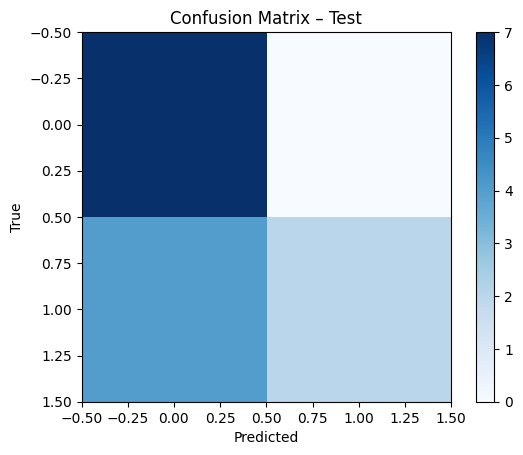

              precision    recall  f1-score   support

     ferrite       0.64      1.00      0.78         7
    pearlite       1.00      0.33      0.50         6

    accuracy                           0.69        13
   macro avg       0.82      0.67      0.64        13
weighted avg       0.80      0.69      0.65        13



In [ ]:
if len(results_df) == 0:
    logs = pd.read_csv(LOG_FILE)
else:
    logs = results_df.copy()

best = logs.loc[logs['ValF1'].idxmax()]
print('Best Validation Run ->')
print(best)

# Recreate generators for best batch size
train_gen, val_gen, test_gen = make_gens(batch_size=int(best['Batch']))

# Build best model
base = build_base(best['Model'])
final_model = build_model(base, float(best['Dropout']))
final_model = compile_with_optimizer(final_model, best['Optimizer'], float(best['LR']), float(best['WeightDecay']))

# Fine-tune: unfreeze last ~8 layers
for layer in base.layers[-8:]:
    layer.trainable = True
final_model = compile_with_optimizer(final_model, best['Optimizer'], float(best['LR'])/10.0, float(best['WeightDecay']))

final_model.fit(train_gen, validation_data=val_gen, epochs=10, verbose=1)

# Test metrics
y_true = test_gen.classes
y_pred = (final_model.predict(test_gen) > 0.5).astype('int32')
t_acc = accuracy_score(y_true, y_pred)
t_prec = precision_score(y_true, y_pred)
t_rec = recall_score(y_true, y_pred)
t_f1 = f1_score(y_true, y_pred)
print(f"\n Test Metrics -> Acc:{t_acc:.3f} | Prec:{t_prec:.3f} | Rec:{t_rec:.3f} | F1:{t_f1:.3f}")

cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix – Test')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.colorbar(); plt.show()
print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))
